# Set up


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/preprocessed.csv")
df.head()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,1st - approved,1st - grade,1st - no evaluations,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations,Target
0,1,0,5,1,1,0,122.0,0,0,1,...,0,0.000000,0,0,0,0,0,0.000000,0,Dropout
1,1,4,1,3,1,0,160.0,0,1,2,...,6,14.000000,0,0,6,6,6,13.666667,0,Graduate
2,1,0,5,1,1,0,122.0,0,0,0,...,0,0.000000,0,0,6,0,0,0.000000,0,Dropout
3,1,0,2,1,1,0,122.0,0,0,0,...,6,13.428571,0,0,6,10,5,12.400000,0,Graduate
4,0,2,1,5,0,0,100.0,0,0,0,...,5,12.333333,0,0,6,6,6,13.000000,0,Graduate


# Feature Engineering


In [2]:
def create_engineered_features(df):
    df = df.copy()
    
    # --- Semester-level features ---
    for sem in ['1st', '2nd']:
        # Readible names
        en_col = f'{sem} - enrolled'
        ap_col = f'{sem} - approved'
        ev_col = f'{sem} - evaluations'
        gr_col = f'{sem} - grade'

        enrolled = df[en_col] if en_col in df.columns else pd.Series(0, index=df.index)
        approved = df[ap_col] if ap_col in df.columns else pd.Series(0, index=df.index)
        evaluations = df[ev_col] if ev_col in df.columns else pd.Series(0, index=df.index)
        grade = df[gr_col] if gr_col in df.columns else pd.Series(0, index=df.index)

        # Handle divided by 0
        df[f'{sem}_approval_rate'] = np.where(enrolled > 0, approved / enrolled, 0.0)
        df[f'{sem}_evaluation_rate'] = np.where(enrolled > 0, evaluations / enrolled, 0.0)
        df[f'{sem}_avg_grade'] = np.where(evaluations > 0, grade / evaluations, 0.0)

    # --- Improvement signals ---
    df['delta_approval_rate'] = df.get('2nd_approval_rate', 0.0) - df.get('1st_approval_rate', 0.0)
    df['delta_avg_grade'] = df.get('2nd_avg_grade', 0.0) - df.get('1st_avg_grade', 0.0)

    # --- Age features ---
    if 'Enroll Age' in df.columns:
        df['Enroll Age'] = pd.to_numeric(df['Enroll Age'], errors='coerce')
        # Simple, interpretable bins:  <=20, 21-24, 25-30, >30
        df['age_group'] = pd.cut(df['Enroll Age'],
                                     bins=[-1, 20, 24, 30, 200],
                                     labels=[0, 1, 2, 3]).astype(float).fillna(3).astype(int)

    return df

df = create_engineered_features(df)
df.to_csv("../data/engineered_features.csv", index=False)
df

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,Target,1st_approval_rate,1st_evaluation_rate,1st_avg_grade,2nd_approval_rate,2nd_evaluation_rate,2nd_avg_grade,delta_approval_rate,delta_avg_grade,age_group
0,1,0,5,1,1,0,122.0,0,0,1,...,Dropout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,4,1,3,1,0,160.0,0,1,2,...,Graduate,1.000000,1.000000,2.333333,1.000000,1.000000,2.277778,0.000000,-0.055556,0
2,1,0,5,1,1,0,122.0,0,0,0,...,Dropout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1,0,2,1,1,0,122.0,0,0,0,...,Graduate,1.000000,1.333333,1.678571,0.833333,1.666667,1.240000,-0.166667,-0.438571,0
4,0,2,1,5,0,0,100.0,0,0,0,...,Graduate,0.833333,1.500000,1.370370,1.000000,1.000000,2.166667,0.166667,0.796296,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,0,6,1,1,0,125.0,0,1,1,...,Graduate,0.833333,1.166667,1.942857,0.833333,1.333333,1.583333,0.000000,-0.359524,0
4420,1,0,2,1,1,0,120.0,1,1,1,...,Dropout,1.000000,1.000000,2.000000,0.333333,1.000000,1.833333,-0.666667,-0.166667,0
4421,1,0,1,4,1,0,154.0,0,0,0,...,Dropout,1.000000,1.142857,1.864062,0.125000,1.125000,1.500000,-0.875000,-0.364062,2
4422,1,0,1,3,1,0,180.0,0,0,0,...,Graduate,1.000000,1.000000,2.760000,1.000000,1.200000,2.000000,0.000000,-0.760000,0


# Visualize


In [3]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print(f"Saving figure {fig_id} at {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure eng_feats at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/eng_feats.png


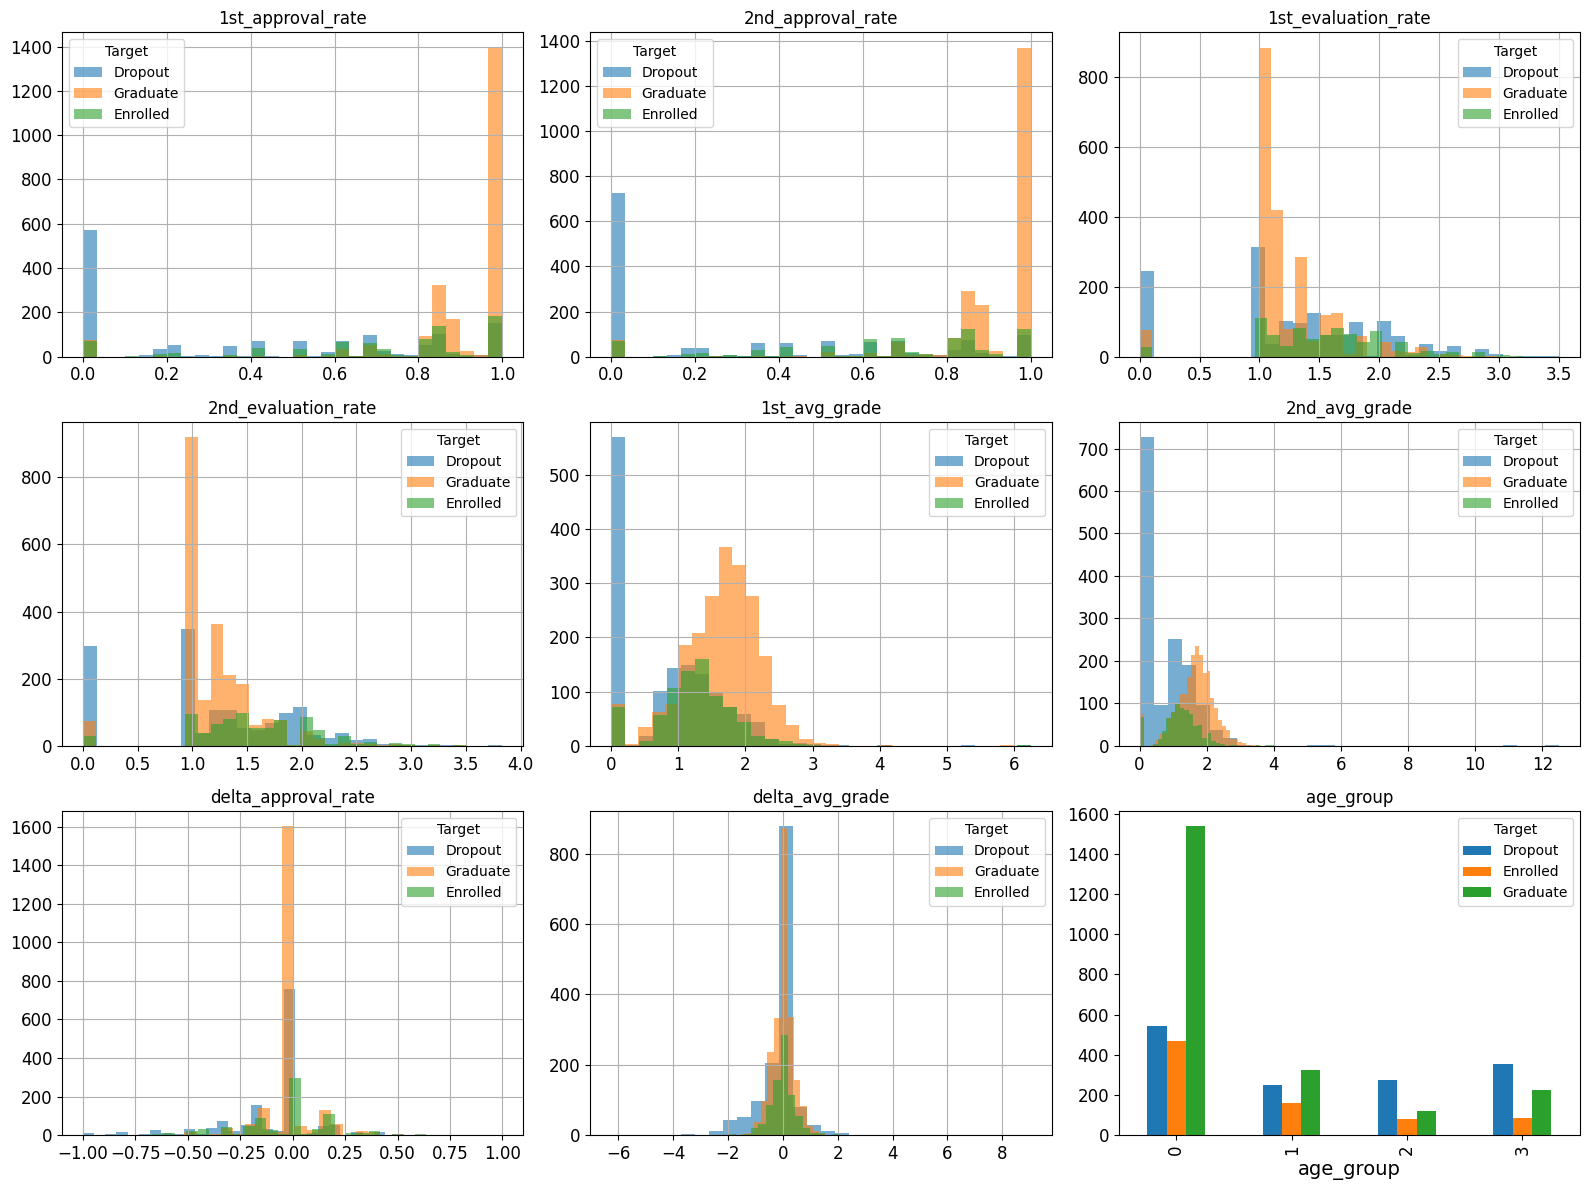

In [4]:
new_feature_cols = [
    '1st_approval_rate', '2nd_approval_rate',
    '1st_evaluation_rate', '2nd_evaluation_rate',
    '1st_avg_grade', '2nd_avg_grade',
    'delta_approval_rate', 'delta_avg_grade',
    'age_group'
]

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.flatten()

for i, col in enumerate(new_feature_cols):
    ax = axs[i]
    # Show by Target: plot distribution/histogram per Target class
    unique_targets = df['Target'].unique()
    if df[col].nunique() < 20:
        # Categorical/discrete: bar by subgroups
        value_counts = df.groupby('Target')[col].value_counts().unstack(fill_value=0).sort_index(axis=1)
        value_counts.T.plot(kind='bar', ax=ax)
        ax.legend(title='Target')
    else:
        # Continuous: histogram for each target
        for target in unique_targets:
            df[df['Target'] == target][col].hist(
                bins=30, alpha=0.6, ax=ax, label=str(target)
            )
        ax.legend(title='Target')
    ax.set_title(col)
plt.tight_layout()
save_fig('eng_feats')

# Train on new Dataset


In [5]:
# Choose numeic features
numeric_cols = [
    'Application order', 'Admission grade', 'Pre Qual (grade)',
    '1st - enrolled', '1st - evaluations',  '1st - approved', 
    '2nd - enrolled', '2nd - evaluations',  '2nd - approved',
    '1st_avg_grade', '1st_approval_rate',
    '2nd_avg_grade', '2nd_approval_rate',
    'delta_approval_rate', 'delta_avg_grade'    
]

# Choose categorical features
categorical_cols = [
    'Marial Status', 'Application mode', 'Course', 'Pre Qual',
    'Nationality', 'Daytime/Evening', 'Scholarship', 'Tuition fees up to date',
    'Displaced', 'Gender', 'International', 'age_group',
    "Mom's Qual", "Mom's Occupation",
    "Dad's Qual", "Dad's Occupation",
]

# Map labels
label_map = {"Graduate": 0, "Enrolled": 1, "Dropout": 2}
df['Target'] = df['Target'].map(label_map)

X = df[numeric_cols + categorical_cols]
y = df['Target']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create processor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='drop'
)

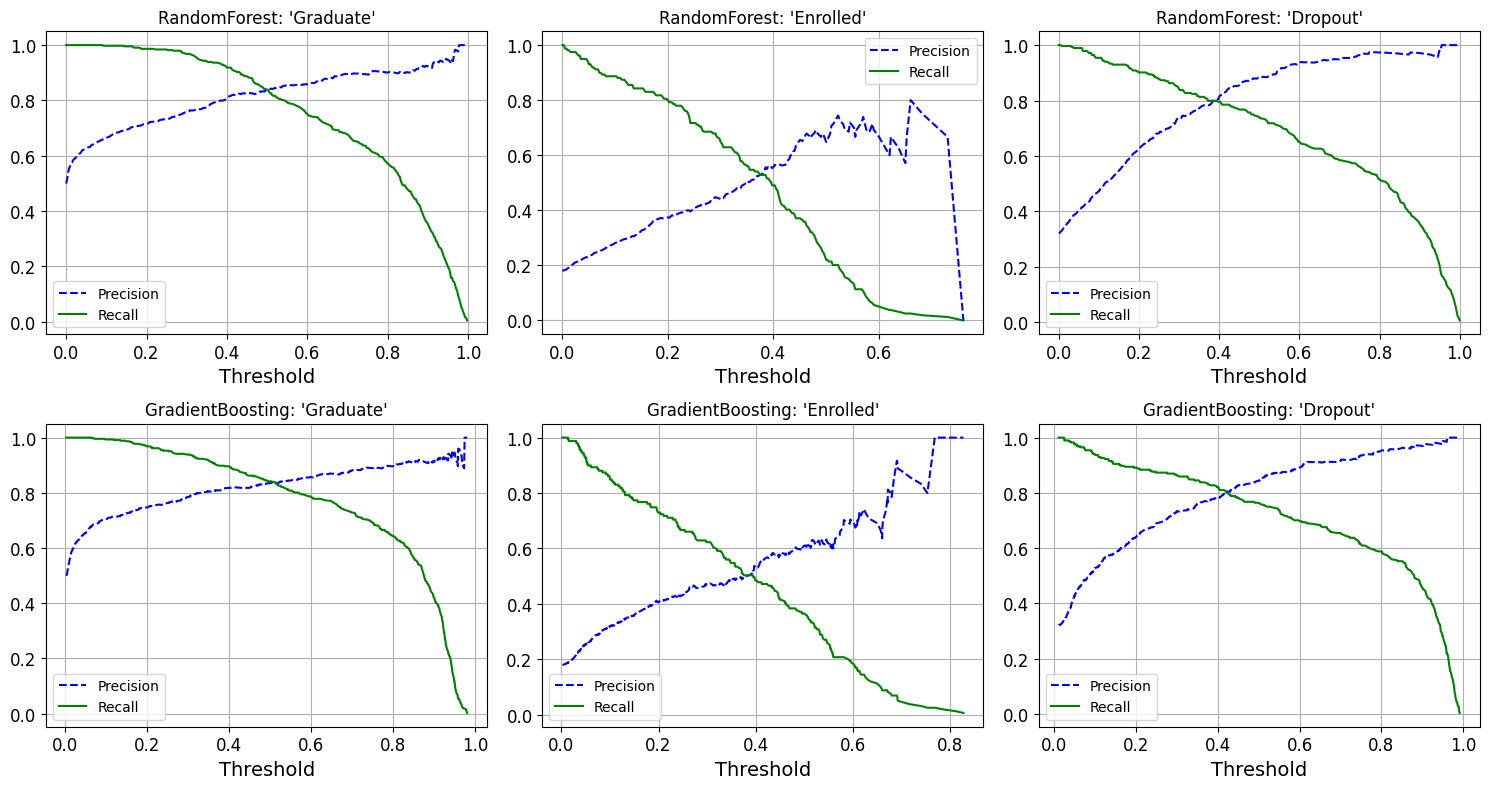

Saving figure precision_recall_curve_enhanced at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/precision_recall_curve_enhanced.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Define train pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
models = {
    'RandomForest': RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, class_weight='balanced_subsample', n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # --- Plot precision-recall vs threshold for all classes as subplots ---
    # For each model, store scores for each class
    if not 'prc_scores' in globals():
        prc_scores = {}
    prc_scores[name] = {}

    for i, class_lbl in enumerate(sorted(y.unique())):
        # Get scores for this class
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_scores = pipe.predict_proba(X_test)[:, i]
        else:
            # fallback for estimators that don't have predict_proba
            if hasattr(pipe.named_steps['model'], "decision_function"):
                y_scores = pipe.decision_function(X_test)
                if y_scores.ndim > 1:
                    y_scores = y_scores[:, i]
            else:
                y_scores = None
        if y_scores is not None:
            y_test_bin = (y_test == class_lbl).astype(int)
            precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_scores)

            prc_scores[name][class_lbl] = (precisions, recalls, thresholds)

    # If last model, plot all subplots
    if name == list(models.keys())[-1]:
        n_models = len(models)
        n_classes = len(sorted(y.unique()))
        fig, axes = plt.subplots(n_models, n_classes, figsize=(5 * n_classes, 4 * n_models), squeeze=False)
        class_name_map = {v: k for k, v in label_map.items()} if "label_map" in globals() else {c: str(c) for c in range(n_classes)}

        for row_i, (model_name, class_dict) in enumerate(prc_scores.items()):
            for col_i, class_lbl in enumerate(sorted(class_dict.keys())):
                precisions, recalls, thresholds = class_dict[class_lbl]
                ax = axes[row_i, col_i]
                ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
                ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
                ax.set_xlabel("Threshold")
                ax.set_title(f"{model_name}: '{class_name_map.get(class_lbl, class_lbl)}'")
                ax.legend(loc="best")
                ax.grid(True)
        plt.tight_layout()
        plt.show()

    # Evaluate model
    try:
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        else:
            roc_auc = None
    except Exception:
        roc_auc = None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'pipeline': pipe,
        'roc_auc_ovr': roc_auc
    }
# save_fig('precision_recall_curve_enhanced')

In [7]:
pd.DataFrame(results).T

,accuracy,f1_macro,f1_weighted,precision_macro,precision_weighted,recall_macro,recall_weighted,pipeline,roc_auc_ovr
RandomForest,0.780791,0.715736,0.771916,0.736498,0.770893,0.705115,0.780791,"(ColumnTransformer(transformers=[('num', Robus...",0.8859
GradientBoosting,0.771751,0.707667,0.764722,0.719111,0.761292,0.701599,0.771751,"(ColumnTransformer(transformers=[('num', Robus...",0.886343


Saving figure confusion_matrix_enhanced at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/confusion_matrix_enhanced.png


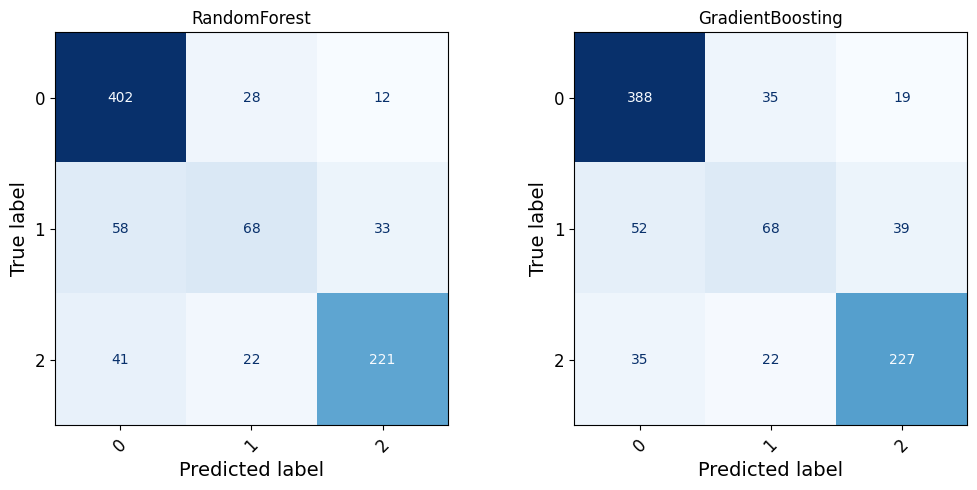

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

model_names = list(results.keys())
y_preds = []
for model in model_names:
    pipe = results[model].get('pipeline')
    if pipe is not None:
        y_pred_model = pipe.predict(X_test)
    else:
        y_pred_model = y_pred
    y_preds.append(y_pred_model)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for idx, (model, y_pred_model) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_pred_model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', xticks_rotation=45, colorbar=False)
    axes[idx].set_title(f"{model}")
plt.tight_layout()
save_fig('confusion_matrix_enhanced')

# Define Grid and Pipelines


In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer

# Define refined hyperparameter grids
rf_param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20, 25, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced_subsample'],
    'criterion': ['gini', 'entropy']
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'subsample': [0.8, 0.9, 1.0],
}

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

# Create pipelines outside of search
def create_rf_pipeline():
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])

def create_gb_pipeline():
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    
# Custom scorer for imbalanced data
f1_scorer = make_scorer(f1_score, average='macro')

# Setup cross-validation with proper stratification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sample_weights = compute_sample_weight('balanced', y_train);

# RandomForest Hyperparameter Search


In [10]:
rf_search = RandomizedSearchCV(
    create_rf_pipeline(),
    param_distributions={'classifier__' + k: v for k, v in rf_param_grid.items()},
    n_iter=50,
    scoring={'f1_macro': f1_scorer, 'accuracy': 'accuracy'}, refit='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)

rf_search.fit(X_train, y_train)
print(f"Best RF CV Score: {rf_search.best_score_:.4f}")
print(f"Best RF Params: {rf_search.best_params_}")

Best RF CV Score: 0.7708
Best RF Params: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 25, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced_subsample'}


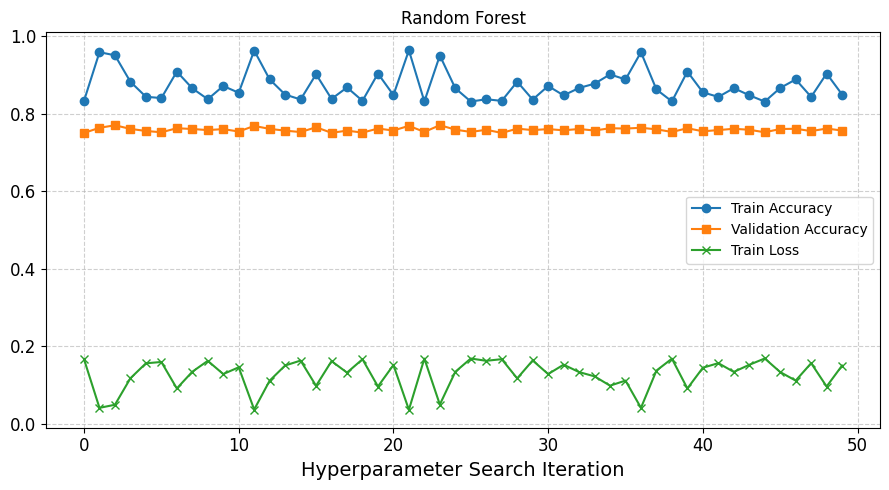

In [11]:
# Extract the CV results
rf_cv_results = rf_search.cv_results_

# Retrieve mean train/validation accuracy and training loss
mean_train_acc = rf_cv_results['mean_train_accuracy']
mean_val_acc = rf_cv_results['mean_test_accuracy']
mean_train_loss = 1 - mean_train_acc

# Plot
plt.figure(figsize=(9, 5))
plt.plot(mean_train_acc, label='Train Accuracy', marker='o')
plt.plot(mean_val_acc, label='Validation Accuracy', marker='s')
plt.plot(mean_train_loss, label='Train Loss', marker='x')
plt.xlabel('Hyperparameter Search Iteration')
plt.title('Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# GradientBoosting Hyperparameter Search


In [12]:
gb_search = RandomizedSearchCV(
    create_gb_pipeline(),
    param_distributions={'classifier__' + k: v for k, v in gb_param_grid.items()},
    n_iter=50,
    scoring={'f1_macro': f1_scorer, 'accuracy': 'accuracy'}, refit='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)

gb_search.fit(X_train, y_train, classifier__sample_weight=sample_weights)
print(f"Best GB CV Score: {gb_search.best_score_:.4f}")
print(f"Best GB Params: {gb_search.best_params_}")

Best GB CV Score: 0.7578
Best GB Params: {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 30, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.15}


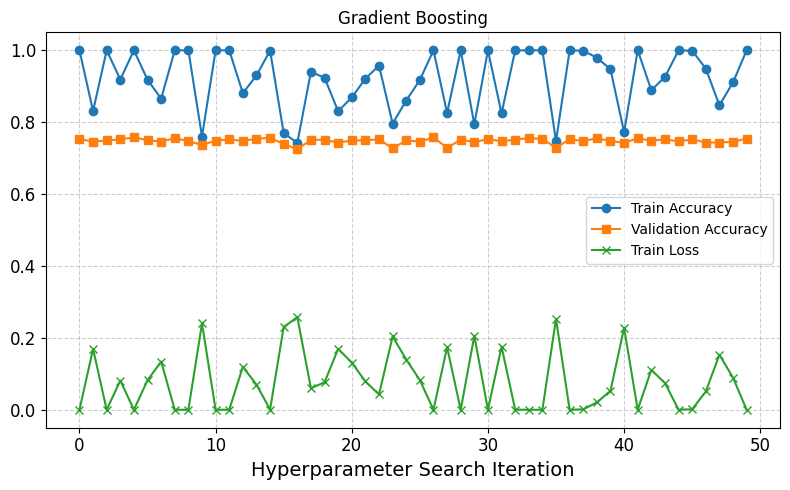

In [13]:
# Extract the CV results for GradientBoosting
gb_cv_results = gb_search.cv_results_

# Retrieve mean train/validation accuracy and training loss
gb_mean_train_acc = gb_cv_results['mean_train_accuracy']
gb_mean_val_acc = gb_cv_results['mean_test_accuracy']
gb_mean_train_loss = 1 - gb_mean_train_acc

# Plot
plt.figure(figsize=(8, 5))
plt.plot(gb_mean_train_acc, label='Train Accuracy', marker='o')
plt.plot(gb_mean_val_acc, label='Validation Accuracy', marker='s')
plt.plot(gb_mean_train_loss, label='Train Loss', marker='x')
plt.xlabel('Hyperparameter Search Iteration')
plt.title('Gradient Boosting')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Evaluate on test set


In [20]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'Precision_Macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall_Macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    }
    return results

# Evaluate both models
rf_results = evaluate_model(rf_search.best_estimator_, X_test, y_test, 'RandomForest')
gb_results = evaluate_model(gb_search.best_estimator_, X_test, y_test, 'GradientBoosting')
comparison_df = pd.DataFrame([rf_results, gb_results])
comparison_df

,Model,Accuracy,F1_Macro,F1_Weighted,Precision_Macro,Recall_Macro,ROC_AUC
0,RandomForest,0.762712,0.718307,0.766627,0.720771,0.719642,0.887097
1,GradientBoosting,0.768362,0.712211,0.765807,0.717474,0.708061,0.881817


Saving figure confusion_matrix_hypetuned at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/confusion_matrix_hypetuned.png


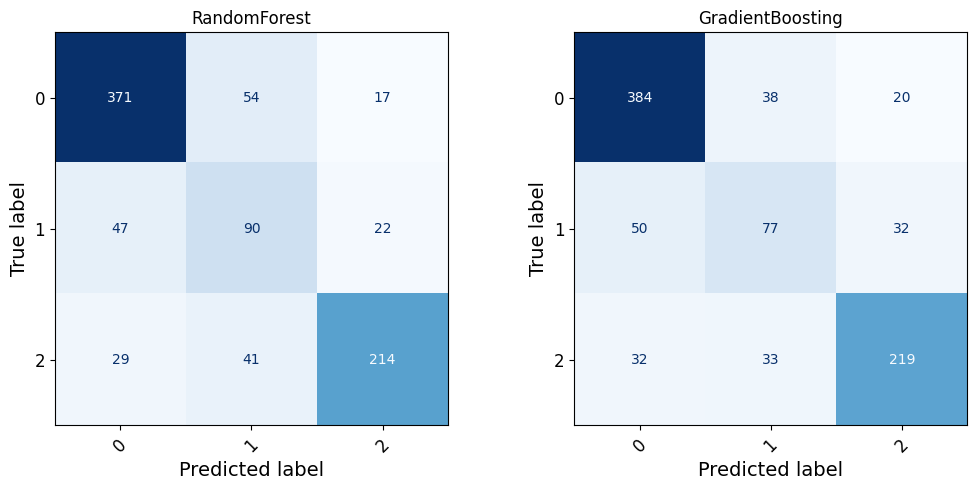

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_names = ['RandomForest', 'GradientBoosting']
models = [rf_search.best_estimator_, gb_search.best_estimator_]
y_preds = [model.predict(X_test) for model in models]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for idx, (name, y_pred) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=axes[idx], cmap='Blues', xticks_rotation=45, colorbar=False)
    axes[idx].set_title(f"{name}")
plt.tight_layout()
save_fig("confusion_matrix_hypetuned")

In [ ]:
print("\n=== Overfitting Analysis ===")
for name, search in [('RandomForest', rf_search), ('GradientBoosting', gb_search)]:
    cv_score = search.best_score_
    test_score = comparison_df.loc[name, 'Accuracy']
    diff = cv_score - test_score
    print(f"{name}:")
    print(f"  CV Score: {cv_score:.4f}")
    print(f"  Test Score: {test_score:.4f}")
    print(f"  Difference: {diff:.4f} {'(HIGH OVERFITTING!)' if diff > 0.05 else '(acceptable)'}")


=== Overfitting Analysis ===
RandomForest:
  CV Score: 0.7708
  Test Score: 0.7627
  Difference: 0.0081 (acceptable)
GradientBoosting:
  CV Score: 0.7578
  Test Score: 0.7684
  Difference: -0.0105 (acceptable)


Saving figure top10_feature_importances_enhanced at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/top10_feature_importances_enhanced.png


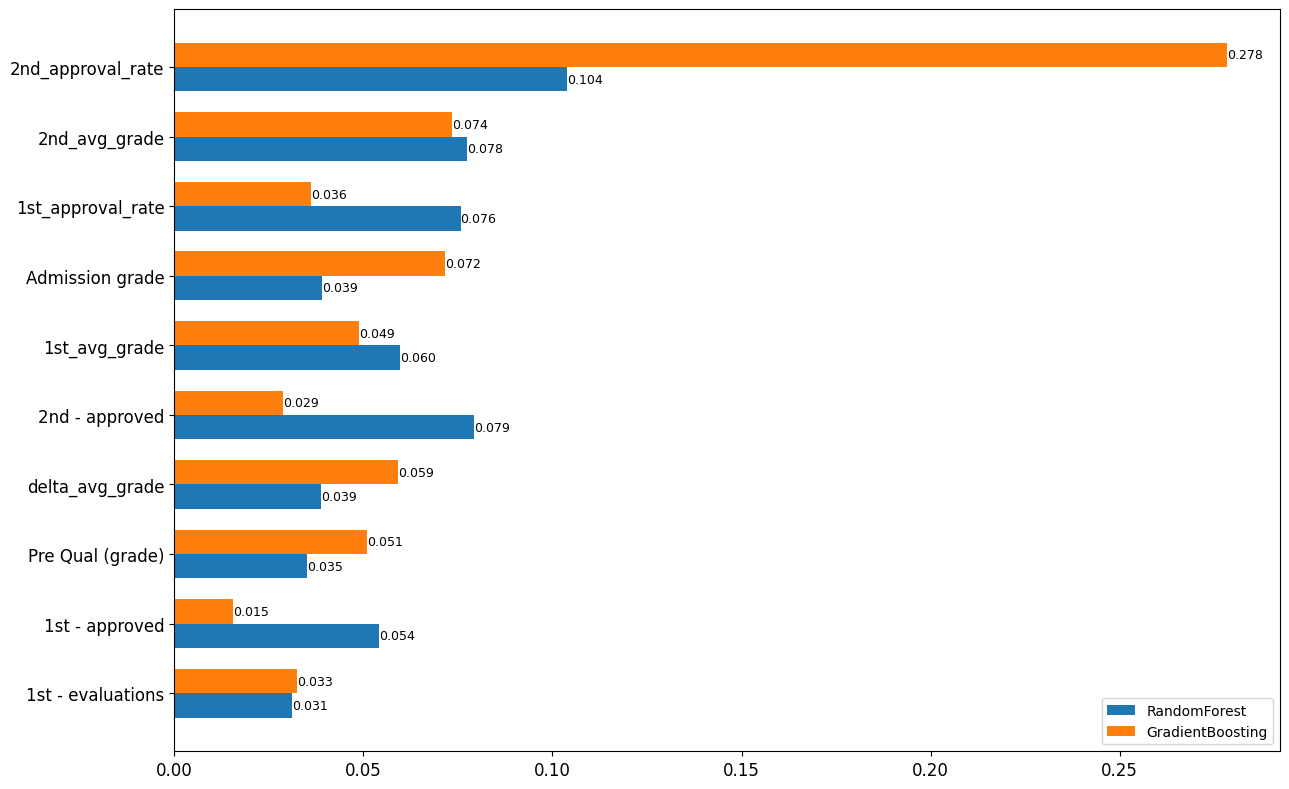

In [ ]:
def plot_top10_feature_importances(rf_model, gb_model, numeric_cols, categorical_cols):
    # Extract feature names: numeric first, then one-hot categorical
    cat_names = rf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = numeric_cols + list(cat_names)

    # Get importances
    rf_importances = rf_model.named_steps['classifier'].feature_importances_
    gb_importances = gb_model.named_steps['classifier'].feature_importances_

    # Match length safety
    n_features = min(len(feature_names), len(rf_importances), len(gb_importances))
    feature_names = feature_names[:n_features]
    rf_importances = rf_importances[:n_features]
    gb_importances = gb_importances[:n_features]

    # Find top-10 for each, then union of indices
    rf_top_idx = np.argsort(rf_importances)[-10:][::-1]
    gb_top_idx = np.argsort(gb_importances)[-10:][::-1]
    all_top_idx = sorted(set(rf_top_idx) | set(gb_top_idx), key=lambda i: -(rf_importances[i] + gb_importances[i]))
    all_top_idx = all_top_idx[:10]  # only top 10 after union+sort

    # Re-index so top feature appears at bottom (barh starts bar from left)
    top_features = [feature_names[i] for i in all_top_idx][::-1]
    rf_top_vals = [rf_importances[i] for i in all_top_idx][::-1]
    gb_top_vals = [gb_importances[i] for i in all_top_idx][::-1]
    y = np.arange(len(top_features))

    width = 0.35
    fig, ax = plt.subplots(figsize=(13, 8))
    bars1 = ax.barh(y - width/2, rf_top_vals, height=width, label='RandomForest')
    bars2 = ax.barh(y + width/2, gb_top_vals, height=width, label='GradientBoosting')

    # Show value labels at end of each bar
    for bars, vals in zip([bars1, bars2], [rf_top_vals, gb_top_vals]):
        for bar, val in zip(bars, vals):
            if val > 0:
                ax.text(
                    bar.get_width(),
                    bar.get_y() + bar.get_height()/2,
                    f"{val:.3f}",
                    va='center', ha='left',
                    fontsize=9, color='black', clip_on=False
                )

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_yticks(y)
    ax.set_yticklabels(top_features)
    ax.legend()
    plt.tight_layout()
    save_fig("top10_feature_importances_enhanced")
    plt.show()

# Plot for best estimators found
plot_top10_feature_importances(rf_search.best_estimator_, gb_search.best_estimator_, numeric_cols, categorical_cols)

# Ensemble Learning


In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_search.best_estimator_),
        ('gb', gb_search.best_estimator_)
    ],
    voting='soft')
ensemble.fit(X_train, y_train)

,estimators,"[('rf', ...), ('gb', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [26]:
rf_results = evaluate_model(rf_search.best_estimator_, X_test, y_test, 'RandomForest')
gb_results = evaluate_model(gb_search.best_estimator_, X_test, y_test, 'GradientBoosting')
ensemble_results = evaluate_model(ensemble, X_test, y_test, 'Ensemble')

results_df = pd.DataFrame([rf_results, gb_results, ensemble_results]).set_index('Model')
results_df

,Accuracy,F1_Macro,F1_Weighted,Precision_Macro,Recall_Macro,ROC_AUC
Model,,,,,,
RandomForest,0.762712,0.718307,0.766627,0.720771,0.719642,0.887097
GradientBoosting,0.768362,0.712211,0.765807,0.717474,0.708061,0.881817
Ensemble,0.776271,0.717525,0.772231,0.725990,0.711494,0.886817
